In [1]:
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm
import os
os.chdir('..')

# QMIX

[Original paper (compact)](https://arxiv.org/pdf/1803.11485.pdf)

[Original paper (extended)](https://arxiv.org/pdf/2003.08839.pdf)

[Original implementation](https://github.com/oxwhirl/pymarl)

- **Only suitable in cooperative environments**
- Value-based multi-agent deep RL algorithm, with DQN foundation
  - Learns value ($Q$) function using experiences sampled from a replay memory
  - Stabilizes target values with target network/parameters
- Each agent $a$ has its own action-value function $Q_a(\tau^a, u^a)$
  - $Q_a$ is represented as a *deep recurrent Q-network* (DRQN), with the use of a gated recurrent unit (GRU)
  - Individual agents can benefit from using their entire action-observation history ($\tau^a$) in partially observable settings
  - $u^a$ is the action to take in the current state
- QMIX performs centralized training by learning a joint action-value function $Q_\text{tot}(\boldsymbol{\tau},\textbf{u})$ where $\boldsymbol{\tau}$ is a joint action-observation history and $\textbf{u}$ is a joint action
  - $Q_\text{tot}$ is composed of $Q_a$ all agents $a$ in a way such that: $$\underset{\textbf{u}}{\mathrm{argmax}}\;Q_\text{tot}(\boldsymbol{\tau},\textbf{u}) = \left\{\underset{\textbf{u}^a}{\mathrm{argmax}}\;Q_a(\tau^a,\text{u}^a)\;|\; \forall a\in A\right\}$$ allowing for decentralized execution
  - The above condition holds as long as $Q_\text{tot}$ is monotonic (increasing) with respect to each $Q_a$: $$\frac{\partial Q_\text{tot}}{\partial Q_a}\ge 0$$

## Network Architecture
- In practice, $Q_\text{tot}$ is the output of a *mixing network* that combines the outputs of each *agent network*, $Q_a$
  - The weights and biases of the mixing network are produced by hypernetworks that take in total state information and also train off of replay memory
  - To ensure monotonicty, the weights produced are set as non-negative via absolute value activation

[Network implementation details here](https://arxiv.org/pdf/2003.08839.pdf#page=13)

![qmix network](<qmix network.png>)

## Algorithm

- $\tau^a$ - individual agent's observation history
- $u^a$ - action chosen by individual agent
- $\textbf{u}$ - joint action (actions of all agents)

![qmix](qmix.png)

# Parameter Sharing

https://arxiv.org/pdf/2005.13625.pdf


In [2]:
import pickle
from scripts.drqn import DRQN
res = {}
with open('testfiles/drqn_cartpole.results', 'rb') as file:
    res = pickle.load(file)

Text(0.5, 1.0, 'Total return')

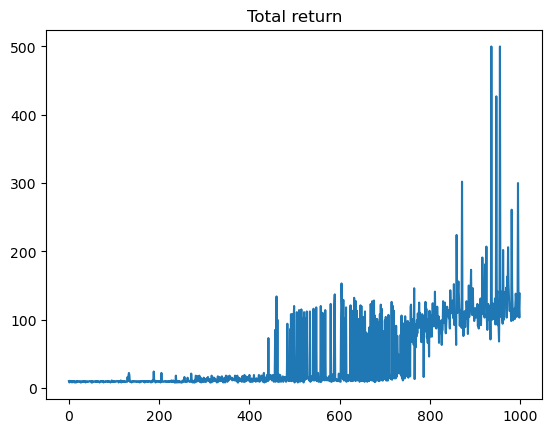

In [3]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), episode_returns)
plt.title('Total return')

(100.0, 1048.95)

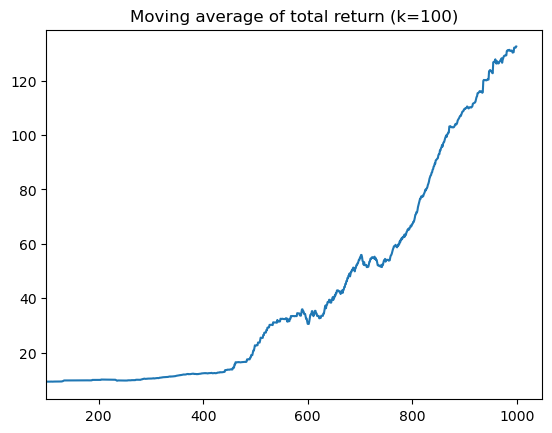

In [9]:
episode_returns = res['episode_returns']
plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
plt.title('Moving average of total return (k=100)')
plt.xlim(left=100)

In [7]:
import gymnasium as gym
from gymnasium.utils.save_video import save_video
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.metadata['render_fps']=30
state = env.reset()[0]
obs_history = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
frames=[]
for t in count():
    frames.append(env.render())
    action = res['final_model'].select_action(obs_history).item()
    state, reward, terminated, truncated, _ = env.step(action)
    obs_history = torch.cat((obs_history, torch.tensor(state, dtype=torch.float32).unsqueeze(0)))
    if terminated or truncated:
        break
save_video(frames, "recordings/drqn", fps=60, name_prefix='drqn1_cartpole')
env.close()

Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\drqn/drqn1_cartpole-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\drqn/drqn1_cartpole-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\drqn/drqn1_cartpole-episode-0.mp4
